In [2]:
!pip install transformers

# Import Libraries:

In [3]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import AutoModel, BertTokenizerFast, AdamW
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load Dataset

In [7]:
# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data and view the first couple of rows 
df = pd.read_csv("./dataset/spamdata_v2.csv")
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Check class distribution of the labels
df["label"].value_counts(normalize=True)

0    0.865937
1    0.134063
Name: label, dtype: float64

# Split dataset into train, validation, and test sets 

In [9]:
train_text, test_val_text, train_labels, test_val_labels = train_test_split(df["text"], df["label"], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df["label"])

# split test_val_text and test_val_labels
test_text, val_text, test_labels, val_labels = train_test_split(test_val_text, test_val_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=test_val_labels
                                                                )

# Import BERT Model and Tokenizer 

In [10]:
# Load Pre-trained BERT model and tokenizer
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenization and Encoding
def tokenize_and_encode(text_data, max_seq_len):
    tokens = tokenizer.batch_encode_plus(
        text_data.tolist(),
        max_length=max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )
    return torch.tensor(tokens['input_ids']), torch.tensor(tokens['attention_mask'])

In [11]:
# Sample data 
text = ["This bert model tutorial, is a fantastic way to learn", "We will fine-tune bert model"]

sent_tokens = tokenizer.tokenize(text)

print(sent_tokens)

# Encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# Print token ids
print(sent_id)

['this', 'bert', 'model', 'tutor', '##ial', ',', 'is', 'a', 'fantastic', 'way', 'to', 'learn', 'we', 'will', 'fine', '-', 'tune', 'bert', 'model']
{'input_ids': [[101, 2023, 14324, 2944, 14924, 4818, 1010, 2003, 1037, 10392, 2126, 2000, 4553, 102], [101, 2057, 2097, 2986, 1011, 8694, 14324, 2944, 102, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]}


# Encode Text Sequences 

<Axes: >

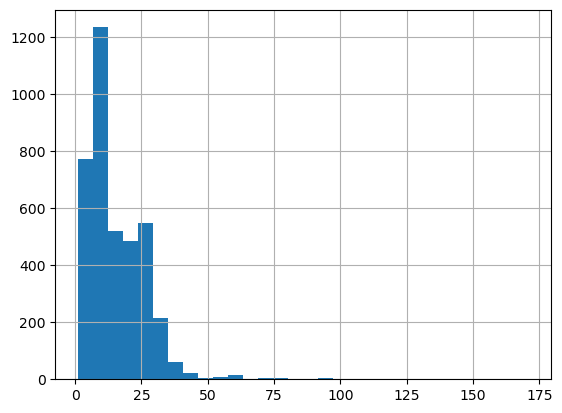

In [12]:
# get length of all the messages in the training set 
seq_len = [len(txt.split()) for txt in train_text]

pd.Series(seq_len).hist(bins= 30)


In [13]:
max_seq_len = 25

In [14]:
# Assume train_text, val_text, test_text, train_labels, val_labels, test_labels are correctly initialized
train_seq, train_mask = tokenize_and_encode(train_text, max_seq_len)
val_seq, val_mask = tokenize_and_encode(val_text, max_seq_len)
test_seq, test_mask = tokenize_and_encode(test_text, max_seq_len)

# Convert labels to tensors
train_y = torch.tensor(train_labels.tolist())
val_y = torch.tensor(val_labels.tolist())
test_y = torch.tensor(test_labels.tolist())

/Users/ghudeihed/anaconda3/envs/XCS330/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Create Dataloaders 

In [15]:
# Prepare DataLoader
batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Freeze BERT Parameters 

In [16]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture 

Adding two fuly connected layers on top of BERT model 

In [17]:
# Define Custom Model Architecture
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768,512)
        self.fc2 = nn.Linear(512,2)
        self.softmax = nn.LogSoftmax(dim=1)

    # Define the forward pass
    def forward(self, sent_id, mask):
        # Pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)
        cls_hs = outputs.last_hidden_state[:, 0, :]  # Take the [CLS] embedding from the last layer
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [18]:
# Instantiate Model and Move to GPU if available
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

# Define Optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

/Users/ghudeihed/anaconda3/envs/XCS330/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# Find Class Weights 

In [19]:
# Compute Class Weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# convert class weights to tensor
weights = torch.tensor(class_wts, dtype=torch.float).to(device)

# Define Loss Function
cross_entropy = nn.NLLLoss(weight=weights)

# Set Number of Epochs
epochs = 10 
print(class_wts)

[0.57743559 3.72848948]


# Fine-Tune BERT

In [20]:
def train(model, train_dataloader, optimizer, device):
    model.train()  # Set the model to training mode

    total_loss, total_accuracy = 0, 0  # Initialize counters for total loss and accuracy

    total_preds = []  # Empty list to save model predictions

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step:>5,}  of  {len(train_dataloader):>5,}.')

        batch = [r.to(device) for r in batch]  # Move the batch to the device (GPU/CPU)

        sent_id, mask, labels = batch  # Unpack the batch
        
        # # Check the data type and shape of the inputs
        # print(f"sent_id type: {type(sent_id)}, shape: {sent_id.shape}")
        # print(f"mask type: {type(mask)}, shape: {mask.shape}")
        # print(f"labels type: {type(labels)}, shape: {labels.shape}")

        model.zero_grad()  # Clear previously calculated gradients

        preds = model(sent_id, mask)  # Get model predictions for the current batch

        loss = cross_entropy(preds, labels)  # Compute the loss between actual and predicted values

        total_loss = total_loss + loss.item()  # Accumulate the total loss

        loss.backward()  # Perform a backward pass to calculate the gradients

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Clip the gradients to 1.0 to prevent exploding gradients

        optimizer.step()  # Update the model parameters

        preds = preds.detach().cpu().numpy()  # Detach predictions from the GPU and convert to numpy array

        total_preds.append(preds)  # Append the model predictions

    avg_loss = total_loss / len(train_dataloader)  # Compute the training loss of the epoch

    total_preds = np.concatenate(total_preds, axis=0)  # Reshape the predictions

    return avg_loss, total_preds  # Return the average loss and predictions

# # Example usage:
# # Assume optimizer and device are already defined
# # model, train_dataloader are from previous snippet
# train_loss, train_preds = train(model, train_dataloader, optimizer, device)


In [21]:
def validate(model, val_dataloader, device):
    model.eval()  # Set the model to evaluation mode

    total_loss, total_accuracy = 0, 0  # Initialize counters for total loss and accuracy

    total_preds = []  # Empty list to save model predictions

    with torch.no_grad():  # Disable gradient computation
        for step, batch in enumerate(val_dataloader):
            if step % 50 == 0 and not step == 0:
                print(f'  Batch {step:>5,}  of  {len(val_dataloader):>5,}.')

            batch = [r.to(device) for r in batch]  # Move the batch to the device (GPU/CPU)

            sent_id, mask, labels = batch  # Unpack the batch

            preds = model(sent_id, mask)  # Get model predictions for the current batch

            loss = cross_entropy(preds, labels)  # Compute the loss between actual and predicted values

            total_loss = total_loss + loss.item()  # Accumulate the total loss

            preds = preds.detach().cpu().numpy()  # Detach predictions from the GPU and convert to numpy array

            total_preds.append(preds)  # Append the model predictions

    avg_loss = total_loss / len(val_dataloader)  # Compute the validation loss of the epoch

    total_preds = np.concatenate(total_preds, axis=0)  # Reshape the predictions

    return avg_loss, total_preds  # Return the average loss and predictions

# # Example usage:
# # model, val_dataloader are from previous snippet
# val_loss, val_preds = validate(model, val_dataloader, device)

# Start Model Training 

In [38]:
def save_model(model, path):
    """Save the model to the specified path."""
    torch.save(model.state_dict(), path)

def train_and_validate(model, train_dataloader, val_dataloader, optimizer, device, epochs):
    best_val_loss = float('inf')  # Initialize best validation loss as infinity

    for epoch in range(epochs):
        print(f'\n Epoch {epoch + 1}/{epochs}')
        train_loss, _ = train(model, train_dataloader, optimizer, device)  # Train the model
        val_loss, _ = validate(model, val_dataloader, device)  # Validate the model

        # If the validation loss is the best seen so far, save the model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(model, f'./models/best_model.pth')
            print(f'Validation loss improved. Model saved to best_model_epoch{epoch + 1}.pth')

        print(f'Training Loss: {train_loss:.3f}')
        print(f'Validation Loss: {val_loss:.3f}')

# Example usage:
# model, train_dataloader, val_dataloader, optimizer, device, and epochs are from previous snippets
train_and_validate(model, train_dataloader, val_dataloader, optimizer, device, epochs)



 Epoch 1/10
  Batch    50  of    122.
  Batch   100  of    122.
Validation loss improved. Model saved to best_model_epoch1.pth
Training Loss: 0.211
Validation Loss: 0.153

 Epoch 2/10
  Batch    50  of    122.
  Batch   100  of    122.
Validation loss improved. Model saved to best_model_epoch2.pth
Training Loss: 0.142
Validation Loss: 0.130

 Epoch 3/10
  Batch    50  of    122.
  Batch   100  of    122.
Validation loss improved. Model saved to best_model_epoch3.pth
Training Loss: 0.124
Validation Loss: 0.120

 Epoch 4/10
  Batch    50  of    122.
  Batch   100  of    122.
Training Loss: 0.091
Validation Loss: 0.120

 Epoch 5/10
  Batch    50  of    122.
  Batch   100  of    122.
Training Loss: 0.102
Validation Loss: 0.140

 Epoch 6/10
  Batch    50  of    122.
  Batch   100  of    122.
Training Loss: 0.083
Validation Loss: 0.121

 Epoch 7/10
  Batch    50  of    122.
  Batch   100  of    122.
Training Loss: 0.105
Validation Loss: 0.135

 Epoch 8/10
  Batch    50  of    122.
  Batch  

# Load Saved Model

In [22]:
# Init the model
model = BERT_Arch(bert)

# Load saved wrights
model.load_state_dict(torch.load("./models/best_model.pth"))

model = model.to(device)  # Move the model to GPU if available

model.eval()  # Set the model to evaluation mode

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

# Get Predictions for Test Data

In [40]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [41]:
# model's performance, 
# since the last layer on our model was a softmax
# We can use argmax here 
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       724
           1       0.92      0.96      0.94       112

    accuracy                           0.98       836
   macro avg       0.96      0.98      0.97       836
weighted avg       0.98      0.98      0.98       836



In [42]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,715,9
1,4,108


In [126]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Assume input_text is your text data
input_text = ["your device is infected with virous", "How are you doing my friend?"]

# Tokenize input text
tokens = tokenizer.batch_encode_plus(
    input_text,
    max_length=25,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)

# Get tensor data
input_ids = tokens['input_ids'].to(device)
attention_mask = tokens['attention_mask'].to(device)

In [127]:
# Disable gradient calculation as we are in inference mode
with torch.no_grad():
    # Forward pass, get predictions
    outputs = model(input_ids, attention_mask)

# Get predicted class indices
_, predicted_indices = torch.max(outputs, dim=1)

# Convert predicted indices to list
predicted_indices = predicted_indices.cpu().tolist()

In [128]:
predicted_indices

[1, 0]